In [1]:
# import needed libraries
import pandas as pd
import helper.Utils as Utils
import matplotlib.pyplot as plt
import re
from transformers import AutoTokenizer
import pandas as pd
import pyterrier as pt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from mono_bert_train import MonoBertTrainer
from mono_bert_test import MonoBertTester
import configure  as cf
from train_set_creator import MonoBertTrainSetCreator
from pyterrier.measures import RR, R, Rprec, P, MAP
import os

2022-07-29 12:12:29.285893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-29 12:12:29.285939: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:

if not pt.started():
    print("Enabling PRF in pyterier")
    # In this lab, we need to specify that we start PyTerrier with PRF enabled
    pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])

Enabling PRF in pyterier
PyTerrier 0.6.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.


Before indexing our data we need to do the following processing steps:


1.   **Remove stopwords.**
2.   **Normalization.**
3.   **Stemming.**

In [3]:


def clean(text):
  '''
  Clean input text form urls, handles, tabs, line jumps, and extra white spaces
  '''
  text = re.sub(r"http\S+", " ", text)  # remove urls
  text = re.sub(r"RT ", " ", text)  # remove rt
  text = re.sub(r"@[\w]*", " ", text)  # remove handles
  text = re.sub(r"[\.\,\#_\|\:\?\?\/\=]", " ", text)# remove special characters
  text = re.sub(r"\t", " ", text)  # remove tabs
  text = re.sub(r"\n", " ", text)  # remove line jump
  text = re.sub(r"\s+", " ", text)  # remove extra white space
  text = text.strip()
  return text


#removing stop sords function
def remove_stop_words(sentence):
  terms=[]
  stop_words= set(stopwords.words('english'))
  words = sentence.split()
  for term in words: 
      if term not in stop_words :
          terms.append(term)
  return " ".join(terms)


def stem(sentence):
    token_words=word_tokenize(sentence)
    return " ".join([porter.stem(word) for word in token_words])


def preprocess(sentence):
  # apply preprocessing steps on the given sentence
  sentence = sentence.lower()
  sentence =remove_stop_words(sentence)
  sentence =stem(sentence)
  return sentence

#define the stemming function
porter=PorterStemmer()

In [4]:

# define some constants.
is_index_built= False
DECIMAL_ROUND = 5
pos_label = 1.0
neg_label = 0.0
RANK = cf.RANK
SCORE = cf.SCORE
TWEET_ID_COLUMN = cf.TWEET_ID_COLUMN
TWEET_TEXT_COLUMN = cf.TWEET_TEXT_COLUMN
VCLAIM_ID = cf.VCLAIM_ID
VCLAIM = cf.VCLAIM
TITLE = cf.TITLE 
LABEL = cf.LABEL
qrels_file=cf.ENG_2021_QRELS
claims_file = cf.ENG_2021_VCLAIMS
evaluation_save_path = cf.ENG_CLEF_2021_EVALUATION_FILE

train_and_dev_query_path = cf.ENG_CLEF_2021_URL_CLEANED_TRAIN_AND_DEV_QUERIES
train_query_path=cf.ENG_CLEF_2021_URL_CLEANED_TRAIN_QUERIES
raw_dev_query = cf.ENG_2021_DEV_QUERIES
expanded_dev_query = cf.ENG_CLEF_2021_URL_CLEANED_DEV_QUERIES
dev_query_path = expanded_dev_query
test_query_path =cf.ENG_CLEF_2021_URL_CLEANED_TEST_QUERIES
eval_metrics=["map",MAP@5, P@1, RR, Rprec, R@5, R@10, R@20, R@50, RR@5]

QUERY = cf.QUERY
QID = cf.QID

NUM_CLASSES = 2
ONE_LAYER = 1
TWO_LAYERS = 2


index_save_path = "./indexes/en-clef-2021-index-multi-field/data.properties"
dev_bm25_run = "./data/runs/bm25_dev_query_en_clef_2021.tsv"
train_bm25_run = "./data/runs/bm25_train_query_en_clef_2021.tsv"
test_bm25_run = "./data/runs/bm25_test_query_en_clef_2021.tsv"
mono_bert_train_vclaim_set = "./data/CLEF_2021/English/train_sets/2021_mono_bert_train_set-vclaim-only.xlsx"
mono_bert_train_title_set = "./data/CLEF_2021/English/train_sets/2021_mono_bert_train_set-title-only.xlsx"
mono_bert_train_both_vclaim_and_title_set = "./data/CLEF_2021/English/train_sets/2021_mono_bert_train_set-both_vclaim_and_title.xlsx"

mono_bert_train_set = mono_bert_train_both_vclaim_and_title_set
mono_bert_dev_set_depth_20= "./data/CLEF_2021/English/dev_sets/en-clef2021-mono_bert_dev_set_top_20.tsv"
mono_bert_dev_set_depth_30= "./data/CLEF_2021/English/dev_sets/en-clef2021-mono_bert_dev_set_top_30.tsv"


random_seeds = [61168821, 129995678, 22612812, 146764631, 21228945, 94412880, 204110176, 6155814, 187372311, 117623077,]

# depth from which negative pairs will be randomly selected from top k documents retrieved from a retrieval model
RANDOM_DEPTH = 20 # RANDOM_DEPTH_FOR_SELECTING_NEGATIVE_DOCUMENTS
search_depth = 100



In [5]:

mono_bert_trainer = MonoBertTrainer(qrels_path=qrels_file,)
mono_bert_tester = MonoBertTester(qrels_path=qrels_file,
                                evaluation_save_path=evaluation_save_path)
                                
random_seeds = [61168821, 129995678, 22612812, 146764631, 21228945, 94412880, 204110176, 6155814, 187372311, 117623077,]



In [6]:
# Read verified claims file
df_claim = Utils.read_file(claims_file)
df_claim[VCLAIM_ID]= df_claim[VCLAIM_ID].astype(str)
df_claim.set_index(VCLAIM_ID, inplace=True)
df_claim

,vclaim,title
vclaim_id,,
vclaim-sno-1-mcdonald39s-any-size-fries,McDonald’s restaurants are offering $1 Any Siz...,$1 McDonald's Any Size Fries
vclaim-sno-10-meter-anaconda,A viral video shows a 10-meter-long anaconda s...,Does Video Show a 10-Meter-Long Anaconda?
vclaim-sno-10-month-old-baby-drawing,A video shows a 10-month-old baby drawing cart...,Is This Really a Video of a 10-Month-Old Baby ...
vclaim-sno-100-facebook-shares-appeal,100 Facebook “shares” will secure a heart tran...,100 Facebook Shares Heart Transplant
vclaim-sno-100-target-coupon,A $100 Target coupon circulated via Facebook i...,$100 Target Coupon on Facebook
...,...,...
vclaim-sno-zookeeper-arrested-molest-gorilla,A 29-year-old San Diego Zoo intern was arreste...,Was a Zookeeper Arrested for Molesting a Gorilla?
vclaim-sno-zoom-teachers-mute,"Zoom allows hosts of meetings, such as educato...",Can Teachers Hear ‘Muted’ Students on Zoom?
vclaim-sno-zuckerberg-dont-share-hoaxes,"Mark Zuckerberg is giving $1,000 away to Faceb...","Mark Zuckerberg Promises $1,000 to Facebook Us..."


## Load QRELs file

In [7]:
def get_qrels(qrels_file):
    df_qrels = pd.read_csv(qrels_file, sep="\t", names=["qid", "Q0", "docno", LABEL])
    df_qrels["qid"]=df_qrels["qid"].astype(str)
    df_qrels["docno"]=df_qrels["docno"].astype(str)
    return df_qrels

df_qrels = get_qrels(qrels_file)
df_qrels

,qid,Q0,docno,label
0,tweet-sno-0,0,vclaim-sno-hero-wombats-australia-fires,1
1,tweet-sno-1,0,vclaim-sno-ilhan-omar-treason-advice-iran,1
2,tweet-sno-2,0,vclaim-sno-us-army-sending-texts-on-draft,1
3,tweet-sno-3,0,vclaim-sno-us-army-sending-texts-on-draft,1
4,tweet-sno-4,0,vclaim-sno-video-of-drone-strike-soleimani,1
...,...,...,...,...
1395,tweet-sno-1397,0,vclaim-sno-trump-covid-fundraising,1
1396,tweet-sno-1398,0,vclaim-sno-amy-coney-barrett-rhodes-scholar,1
1397,tweet-sno-1399,0,vclaim-sno-biden-fail-condemn-antifa,1
1398,tweet-sno-1400,0,vclaim-sno-trump-condemn-white-supremacists,1


## Create multi-fields index

In [8]:
def build_index(claims_file=cf.ENG_2021_VCLAIMS, index_path="./indexes/en-clef-2021-index-multi-field"):

    def get_document():
        for i, row in df_doc.iterrows():
            yield {"docno": row[VCLAIM_ID], "text": row[VCLAIM], "title": row[TITLE]}

    # load the documents (verified claims) and apply preprocessing steps over them
    df_doc = Utils.read_file(claims_file)  
    df_doc[VCLAIM] = df_doc[VCLAIM].apply(preprocess)
    df_doc[TITLE] = df_doc[TITLE].apply(preprocess)
    df_doc["text"] = df_doc[VCLAIM].astype(str)
    df_doc["docno"] = df_doc[VCLAIM_ID].astype(str)


    iter_indexer = pt.IterDictIndexer(index_path,  overwrite=True, verbose=True)
    # the default is an English tokenizer: Tokenises text obtained from a text stream assuming English language.
    iter_indexer.setProperty("tokeniser", "EnglishTokeniser")
    indexref3 = iter_indexer.index(get_document(), fields=["text", "title"], meta=['docno'])
    print(indexref3.toString())

    # first load the index
    multi_field_index = pt.IndexFactory.of(indexref3)
    print("Index was build on path ", indexref3.toString())
    print(multi_field_index.getCollectionStatistics().toString())

    return multi_field_index

def load_index(index_path):
    try:
            # first load the index
        multi_field_index = pt.IndexFactory.of(index_path)
        # call getCollectionStatistics() to check the stats
        print(multi_field_index.getCollectionStatistics().toString())
        print("Index has been loaded successfully")
        return multi_field_index
    except Exception as e:
        print('Cannot load the index, check exception details {}'.format(e))
        return []


multi_field_index = load_index(index_path=index_save_path)

Number of documents: 13825
Number of terms: 14822
Number of postings: 163240
Number of fields: 2
Number of tokens: 228726
Field names: [text, title]
Positions:   false

Index has been loaded successfully


## Searching function


In [9]:
def clean_query_for_search(query_path, data_column="cleaned"):

    print("Cleaning queries and applying preprocessing steps")
    df_query = Utils.read_file(query_path)
    # try test quries after extracting some information from urls
    df_query[QUERY] =df_query[data_column].apply(clean)
    df_query[QUERY] =df_query[QUERY].apply(Utils.remove_emoji_smileys)
    df_query[QUERY] =df_query[QUERY].apply(Utils.remove_punctuation)
    df_query[QUERY] = df_query[QUERY].apply(preprocess)
    df_query[QID] = df_query[TWEET_ID_COLUMN].astype(str)
    df_query = df_query[[QID, QUERY]]
    print("Done with cleaning!")
    return df_query
    
def search_and_evaluate(query_path, run_save_path, retrieval_model="BM25", evaluation_path="",
                        data_column='cleaned', depth=100, method_name="BM25"):
    
    df_query = clean_query_for_search(query_path, data_column=data_column)
    # intialize BM25 model to get the top 100 potentially relevant documents
    bm25_retr = pt.BatchRetrieve(multi_field_index, controls = {"wmodel": retrieval_model},num_results=depth)
    print("Searching for the queries .....")
    # retrieve potentially relevant documents for each query in queries file
    bm25_res = bm25_retr.transform(df_query)
    # save the run in trec format
    bm25_res.to_csv(run_save_path, header=False, index=False, sep='\t')


    # Evaluate the performance
    print("Perfomring evaluation ......")
    bm25_eval = pt.Utils.evaluate(bm25_res, df_qrels[["qid", "docno", LABEL]],metrics=eval_metrics)
    bm25_eval.update({"name": method_name})
    bm25_eval.update({"depth": depth})
    bm25_eval = pd.DataFrame([bm25_eval])
    bm25_eval = bm25_eval.round(DECIMAL_ROUND)

    # save evaluation results
    if evaluation_path != "":
        if not os.path.isfile(evaluation_path): # if file is not exist, create a new one
            bm25_eval.to_excel(evaluation_path, index=False)
        else: # it is already exist, append current evaluation to it
            df_eval = Utils.read_file(evaluation_path)
            df_eval = df_eval.append(bm25_eval, ignore_index=True)
            df_eval.to_excel(evaluation_path, index=False)
    
    
    
    print("Done searching and evaluation ")
    return bm25_res, bm25_eval
    

In [10]:
# 1. Read test queries

df_dev_query  = clean_query_for_search(raw_dev_query, data_column=TWEET_TEXT_COLUMN)
df_dev_query_after_preprocessing = clean_query_for_search(expanded_dev_query, data_column="cleaned")

# retrieval models
depth = 100 
JM = pt.BatchRetrieve(multi_field_index,wmodel="Hiemstra_LM",controls ={"c":0.05},num_results=depth)
bm25_retr = pt.BatchRetrieve(multi_field_index, controls = {"wmodel": "BM25",},num_results=depth)
DPH = pt.BatchRetrieve(multi_field_index,wmodel="DPH", num_results=depth)
DLH = pt.BatchRetrieve(multi_field_index,wmodel="DLH", num_results=depth)
DFR_BM25 = pt.BatchRetrieve(multi_field_index,wmodel="DFR_BM25", num_results=depth)
rm3_pipe = bm25_retr >> pt.rewrite.RM3(multi_field_index,fb_terms=10, fb_docs=3) >> bm25_retr

retrieval_models = [JM, bm25_retr, DPH, DLH, DFR_BM25, rm3_pipe]
retreival_model_names =  ["JM", "BM25", "DPH", "DLH", "DFR_BM25", "rm3_pipe"]

df_eval_all = pd.DataFrame()
for i in range(len(retrieval_models)):
    retrieval_model = retrieval_models[i]
    retrieval_model_name = retreival_model_names[i]

    retrieval_list = retrieval_model.transform(df_dev_query)
    retrieval_list_after_preprocessing= retrieval_model.transform(df_dev_query_after_preprocessing)


    df_eval = pt.Experiment([retrieval_list, retrieval_list_after_preprocessing],
                df_dev_query,
                df_qrels[["qid", "docno", LABEL]],
                eval_metrics=eval_metrics,
                names=[retrieval_model_name, retrieval_model_name+"+PreP"],
                baseline=0)
    df_eval_all = df_eval_all.append(df_eval, ignore_index=True)



df_eval_all.to_excel("./data/en-2021_classic_retrieval_with_preprocessing_on_dev.xlsx", index=False)
df_eval_all

Cleaning queries and applying preprocessing steps
Done with cleaning!
Cleaning queries and applying preprocessing steps
Done with cleaning!


,name,map,Rprec,RR,P@1,R@5,R@10,R@20,R@50,AP@5,...,R@20 p-value,R@50 +,R@50 -,R@50 p-value,AP@5 +,AP@5 -,AP@5 p-value,RR@5 +,RR@5 -,RR@5 p-value
0,JM,0.880876,0.844221,0.880876,0.844221,0.929648,0.934673,0.949749,0.954774,0.878894,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,JM+PreP,0.914051,0.884422,0.914051,0.884422,0.954774,0.959799,0.964824,0.964824,0.913065,...,0.083261,3.0,1.0,0.318531,11.0,1.0,0.004128,10.0,0.0,0.002646
2,BM25,0.892202,0.864322,0.892202,0.864322,0.924623,0.929648,0.949749,0.954774,0.889447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BM25+PreP,0.923946,0.904523,0.923946,0.904523,0.944724,0.949749,0.964824,0.964824,0.921692,...,0.083261,3.0,1.0,0.318531,9.0,1.0,0.008511,8.0,0.0,0.005957
4,DPH,0.870232,0.834171,0.870232,0.834171,0.924623,0.934673,0.944724,0.954774,0.867755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,DPH+PreP,0.892412,0.849246,0.892412,0.849246,0.949749,0.959799,0.964824,0.969849,0.890620,...,0.045223,3.0,0.0,0.083261,9.0,3.0,0.043046,8.0,2.0,0.032985
6,DLH,0.891557,0.864322,0.891557,0.864322,0.929648,0.944724,0.944724,0.954774,0.889363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,DLH+PreP,0.919877,0.894472,0.919877,0.894472,0.949749,0.959799,0.964824,0.964824,0.918090,...,0.045223,3.0,1.0,0.318531,9.0,1.0,0.011384,8.0,0.0,0.007683
8,DFR_BM25,0.891849,0.864322,0.891849,0.864322,0.924623,0.929648,0.949749,0.954774,0.889196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,DFR_BM25+PreP,0.923592,0.904523,0.923592,0.904523,0.944724,0.949749,0.964824,0.964824,0.921441,...,0.083261,3.0,1.0,0.318531,9.0,1.0,0.008511,8.0,0.0,0.005957


## Create training data for mono BERT

In [11]:
def create_train_set(mono_train_set_creator, train_query_path, train_bm25_run_path, bm25_evaluation_save_path,train_set_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", depth_of_random=20,
                    what_to_add=cf.VCLAIM_AND_TITLE,  add_similarity=False, lang="en"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation")
    mono_train_set_creator.search_and_evaluate(query_path=train_query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=train_bm25_run_path, 
                        depth=search_depth, method_name="bm25_train+dev", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating train set")
    mono_train_set_creator.create_train_pairs(train_query_path, train_bm25_run_path, train_set_save_path, 
                            query_column="cleaned", what_to_add=what_to_add, 
                            depth_of_random=depth_of_random, add_similarity=add_similarity,)
    print("Done creating train set")





In [12]:
mono_train_set_creator = MonoBertTrainSetCreator(qrels_file, claims_file, index_save_path, eval_metrics)
mono_bert_trainer = MonoBertTrainer(train_query_path, dev_query_path, qrels_path=qrels_file,)
mono_bert_tester = MonoBertTester(qrels_path=qrels_file,
                                evaluation_save_path=evaluation_save_path)


Number of documents: 13825
Number of terms: 14822
Number of postings: 163240
Number of fields: 2
Number of tokens: 228726
Field names: [text, title]
Positions:   false

Index has been loaded successfully


In [ ]:


df_train_set_both = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_both_vclaim_and_title_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.VCLAIM_AND_TITLE, add_similarity=False,)

df_train_set_title_only = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_title_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.TITLE_ONLY, add_similarity=False,)

df_train_set_vclaim = create_train_set(mono_train_set_creator, train_query_path, train_bm25_run, "",
                    train_set_save_path=mono_bert_train_vclaim_set, 
                    search_depth=search_depth, query_column="cleaned", retrieval_model="BM25", depth_of_random=RANDOM_DEPTH,
                    what_to_add=cf.VCLAIM_ONLY, add_similarity=False,)


Make runs and evaluation
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating train set
Processing tweet number 0 with tweet id tweet-sno-0 
Processing tweet number 100 with tweet id tweet-sno-100 
Processing tweet number 200 with tweet id tweet-sno-200 
Processing tweet number 300 with tweet id tweet-sno-300 
Processing tweet number 400 with tweet id tweet-sno-400 
Processing tweet number 500 with tweet id tweet-sno-500 
Processing tweet number 600 with tweet id tweet-sno-600 
Processing tweet number 700 with tweet id tweet-sno-700 
Processing tweet number 800 with tweet id tweet-sno-800 
Processing tweet number 900 with tweet id tweet-sno-901 
Done creating train set
Make runs and evaluation
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for Englis

Helpful function for creating the dev and test sets in monoBERT fashion

In [ ]:

# create test set suitable for mono BERT re-ranker
def create_test_set(mono_train_set_creator, query_path, run_path, bm25_evaluation_save_path, pairs_save_path, 
                    search_depth=100, query_column="cleaned", retrieval_model="BM25", lang="en"):


   # 1- create run for both dev and train queries
    print("Make runs and evaluation for depth ", search_depth)
    mono_train_set_creator.search_and_evaluate(query_path=query_path, evaluation_path=bm25_evaluation_save_path, 
                        retrieval_model=retrieval_model, run_save_path=run_path, 
                        depth=search_depth, method_name="bm25_dev-or-test", data_column=query_column, lang=lang)
    print("Done with runs and evaluation")

    # 2- create the training set
    print("Creating test/dev set for mono BERT from queries path: ", query_path)
    mono_train_set_creator.create_test_pairs(query_path, run_path, query_column="cleaned", 
                    pairs_save_path=pairs_save_path,)
    print("Done creating test set for mono BERT")
    
    return  


## Create dev sets from top k retrieved documents by bm25

In [ ]:

depths = [10, 20, 30, 50, 100,]
for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_dev_query_en_clef_2021_depth_" + str(depth) + ".tsv"
    mono_bert_dev_set = "./data/CLEF_2021/English/dev_sets/en-clef2021-mono_bert_dev_set_top_" + str(depth) + ".tsv"

    create_test_set(mono_train_set_creator, dev_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_dev_set, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="en")


Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/English/url_cleaned_dev_queries_2021.xlsx
1000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/English/url_cleaned_dev_queries_2021.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
3000  rows have been created so far 
Done creating test set for mono BERT
Make runs and 

------------------------------------------------------------------------------------
## Create test sets from top k documents retrieved by bm25
------------------------------------------------------------------------------------

In [16]:
depths = [10, 20, 30, 50, 100,]

for i in range(len(depths)):
    depth = depths[i]
    bm25_run_path =  "./data/runs/bm25_test_query_en_clef_2021_depth_" + str(depth) + ".tsv"
    mono_bert_test_set_path = "./data/CLEF_2021/English/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"

    
    create_test_set(mono_train_set_creator, test_query_path, bm25_run_path, 
                    bm25_evaluation_save_path="", pairs_save_path=mono_bert_test_set_path, 
                    search_depth=depth, query_column="cleaned", retrieval_model="BM25", lang="en")




Make runs and evaluation for depth  10
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/English/url_cleaned_test_queries_2021.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
Done creating test set for mono BERT
Make runs and evaluation for depth  20
Cleaning queries and applying preprocessing steps
Applying lowercasing, stemming and stop word removal for English
Done with cleaning!
Searching for the queries .....
Done searching and evaluation 
Done with runs and evaluation
Creating test/dev set for mono BERT from queries path:  ./data/CLEF_2021/English/url_cleaned_test_queries_2021.xlsx
1000  rows have been created so far 
2000  rows have been created so far 
3000  rows have been created so far 
4000  rows h

Get the maximum length needed to tokenize a pair of query and document in the training set

Maximum length of a tokenized example is :  222
Sentence Lengths: 


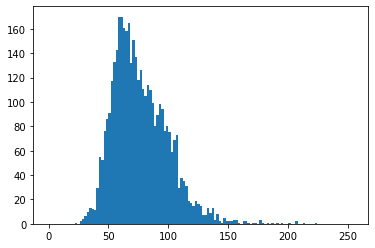

Number of documents that are bigger than max legnth 
5


In [13]:
# measure the maximum length needed to tokenize a triplet
def get_pairs_max_length(data_path, tokenizer, max_length):
    df = Utils.read_file(data_path)
    lengths = []
    maxl = 0
    for i, row in df.iterrows():
        query = row[TWEET_TEXT_COLUMN]
        document = row[VCLAIM]
        row_len = len(tokenizer.tokenize(query)) +len(tokenizer.tokenize(document))
        lengths.append(row_len)
        maxl = max(maxl, row_len)
    print("Maximum length of a tokenized example is : ", maxl)
    print("Sentence Lengths: ")
    plt.hist(lengths ,bins=range(0,256,2))
    plt.show()

    print("Number of documents that are bigger than max legnth ")
    print(sum([length > max_length for length in lengths]))
    
    return 

BERT = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(BERT)
get_pairs_max_length(mono_bert_train_set ,tokenizer, max_length=200)

## Tuning the model on dev set to figure out the best depth of the initial retrieved list

In [14]:
depth_evaluation_file = "./data/evaluation/en-clef-2021-mono-bert-depth-evaluation-on-dev-set.xlsx"
bert_models = [ "sentence-transformers/stsb-mpnet-base-v2",]# just the best performed model are chosen for this step
models_names = ["stsb-mpnet-base-v2",]

num_rand_seeds  = 5
seeds = random_seeds[:num_rand_seeds]
for i in range(len(bert_models)):
    l = 0
    seed = seeds[l]
    bert_model = bert_models[i]
    model_name = models_names[i]
    print("---------- training for model : --------", model_name)
    hp = { # hyper parameters
    "model_name": bert_model,
    "name": model_name +"-seed-"+ str(seed),
    "model_save_path": "./data/saved_models/EN-clef2021-"+model_name+"_mono_trained_model-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/en-clef2021-mono_"+model_name+"_training_log-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "num_of_epochs": [5], 
    "learning_rate" : [2e-5,],
    "dropout": [0.3,], 
    "seeds": [seed],
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
   


    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)


    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout

    depths = [10, 20, 30, 50, 100,]
    for k in range(len(depths)):
        depth = depths[k]
        mono_bert_dev_set = "./data/CLEF_2021/English/dev_sets/en-clef2021-mono_bert_dev_set_top_" + str(depth) + ".tsv"
        hp["test_depth"] = depth
        run_name = "en-clef-2021-mono_"+model_name+"_rerankded_data-dev-set_of_top_"+str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name 
        hp["trec_run_path"] = "./data/runs/trec_eval/EN2021/"+ run_name
        
        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_dev_set, 
                            hp["reranked_data_path"],  depth_evaluation_file, max_len=hp["max_len"], batch_size=hp["batch_size"],
                            dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                            hyper_parameters=hp, classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                            what_to_test=cf.VCLAIM_AND_TITLE)


---------- training for model : -------- stsb-mpnet-base-v2
device:  cuda:0
train size  3996
dev size  3980
Epoch 1/5
----------
  Batch    40  of    125.    Elapsed: 0:00:32.
  Batch    80  of    125.    Elapsed: 0:01:03.
  Batch   120  of    125.    Elapsed: 0:01:35.

  correct_predictions: 3189.00
  Accuracy : 0.80
  Average training loss: 0.41
relevance results F1 score  0.786451442180471  precision 0.8343627175743964 recall 0.7437437437437437
 Macro F1 0.7974507388922768 Weighted F1 0.7974507388922768 Accuracy 0.7980480480480481
Train loss 0.4148215020895004 accuracy 0.7980480480480481
Running Evaluation...
  Batch   100  of    125.    Elapsed: 0:00:28.
Done with re-ranking tweets 
Output is saved into  
Trec run is saved into  ./data/runs/dev_resuable_trec_run.tsv
 
 Done evaluation  -------------------
  Map measure : 0.93
  Accuracy: 0.97
  Average Validation loss: 0.13 

Dev loss 0.12558557152748107 accuracy 0.97035175879397 eval_measures {'map': 0.932719151312116, 'AP@5': 0.9

## Start training sentence BERT models

In [13]:
bert_models = [
            "sentence-transformers/paraphrase-mpnet-base-v2",
            "sentence-transformers/paraphrase-multilingual-mpnet-base-v2",
            "sentence-transformers/stsb-mpnet-base-v2",
            "sentence-transformers/msmarco-roberta-base-v2",
            "sentence-transformers/paraphrase-MiniLM-L12-v2",
            "bert-base-cased",
            ]
models_names = [
            "paraphrase-mpnet-base-v2",
            "paraphrase-multilingual-mpnet-base-v2",
            "stsb-mpnet-base-v2",
            "msmarco-roberta-base-v2",
            "paraphrase-MiniLM-L12-v2",
            "BERT",
            ]
            
num_rand_seeds  = 5
seeds = random_seeds[:num_rand_seeds]
for i in range(len(bert_models)):
    l = 0
    seed = seeds[l]
    bert_model = bert_models[i]
    model_name = models_names[i]
    print("---------- training for model : --------", model_name)
    hp = { # hyper parameters

    "model_name": bert_model,
    "name": model_name +"-seed-"+ str(seed),
    "model_save_path": "./data/saved_models/EN-clef2021-"+model_name+"_mono_trained_model-tuning-seed-"+ str(seed)+".bin",
    "model_training_log": "./data/bert_evaluation/en-clef2021-mono_"+model_name+"_training_log-tuning-seed-"+ str(seed)+".xlsx",
    "batch_size": 32,
    "test_depth": 30,
    "num_of_epochs": [3, 4, 5], 
    "learning_rate" : [2e-5, 3e-5],
    "dropout": [0.3, 0.4,], 
    "seeds": [seed],
    "max_len": 256,
    "curricula_type": 0,
    "end_of_curriculum": [0],
    "num_of_layers": ONE_LAYER,
    "is_output_probability": False, # if false, put loss_function = mono_loss, otherwise put loss_function=CrossEntropy
    "loss_function": "mono_loss"}
   


    _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)


    # store the best hyperparameters
    hp["num_of_epochs"]= best_num_of_epochs
    hp["learning_rate"]= best_learning_rate
    hp["end_of_curriculum"]= best_end_of_curriculum
    hp["dropout"]= best_dropout


    # measure the performance on the test set
    depths = [20,]
    for k in range(len(depths)):
        depth = depths[k]
        hp["test_depth"] = depth
        mono_bert_test_set_path = "./data/CLEF_2021/English/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"
        run_name = "en-clef2021-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
        hp["reranked_data_path"] = "./data/runs/" + run_name
        hp["trec_run_path"] = "./data/runs/trec_eval/EN2021/"+ run_name

        mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                        hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                        dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                        hyper_parameters=hp, classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                        what_to_test=cf.VCLAIM_AND_TITLE)


    # then we get the best hyper parameters values
    # and we can run the training with different random seeds

    l = 1
    while l < num_rand_seeds:
        seed = seeds[l]
        l = l + 1
        hp["name"] = model_name +"-seed-"+ str(seed)
        hp["model_save_path"]= "./data/saved_models/EN-clef2021-"+model_name+"_mono_trained_model-tuning-seed-"+ str(seed)+".bin"
        hp["model_training_log"]= "./data/bert_evaluation/en-clef2021-mono_"+model_name+"_training_log-tuning-seed-"+ str(seed)+".xlsx"
        hp["learning_rate"]= [best_learning_rate]
        hp["num_of_epochs"]= [best_num_of_epochs]
        hp["end_of_curriculum"]= [best_end_of_curriculum]
        hp["dropout"]= [best_dropout]
        hp["seeds"] = [seed]


        _, _, best_learning_rate, best_num_of_epochs, best_end_of_curriculum, best_dropout = mono_bert_trainer.train_mono_bert(
                        mono_bert_train_set, mono_bert_dev_set_depth_20, hp["model_name"], apply_cleaning=False,  seeds=hp["seeds"],
                        trained_model_save_path=hp["model_save_path"], shuffle=True, freeze_bert=False, max_len=hp["max_len"], 
                        batch_size=hp["batch_size"],epochs=hp["num_of_epochs"], learning_rates = hp["learning_rate"],
                        is_output_probability=hp["is_output_probability"],  end_of_curriculums=hp["end_of_curriculum"],
                        curricula_type=hp["curricula_type"], dropout=hp["dropout"], hp=hp, results_path=hp["model_training_log"],
                        classifier_layers=hp["num_of_layers"], what_to_eval=cf.VCLAIM_AND_TITLE)

        # store the best hyperparameters
        hp["num_of_epochs"]= best_num_of_epochs
        hp["learning_rate"]= best_learning_rate
        hp["end_of_curriculum"]= best_end_of_curriculum
        hp["dropout"]= best_dropout


         # measure the performance on the test set
        depths = [20,]
        for k in range(len(depths)):
            depth = depths[k]
            hp["test_depth"] = depth
            mono_bert_test_set_path = "./data/CLEF_2021/English/test_sets/mono_bert_test_set_top_" + str(depth) + ".tsv"
            run_name = "en-clef2021-mono_"+model_name+"-seed-"+str(seed)+"_rerankded_data-depth_" +str(depth)+".tsv"
            hp["reranked_data_path"] = "./data/runs/" + run_name
            hp["trec_run_path"] = "./data/runs/trec_eval/EN2021/"+ run_name

            mono_bert_tester.test_mono_bert(hp["model_name"], hp["model_save_path"], mono_bert_test_set_path, 
                            hp["reranked_data_path"],  evaluation_save_path, max_len=hp["max_len"], batch_size=hp["batch_size"],
                            dropout=hp["dropout"], apply_cleaning=False, is_output_probability=hp["is_output_probability"], 
                            hyper_parameters=hp, classifier_layers=hp["num_of_layers"], trec_run_path=hp["trec_run_path"],
                            what_to_test=cf.VCLAIM_AND_TITLE)



---------- training for model : -------- paraphrase-mpnet-base-v2
device:  cuda:0
train size  3996
dev size  3980
Epoch 1/3
----------
  Batch    40  of    125.    Elapsed: 0:00:32.
  Batch    80  of    125.    Elapsed: 0:01:04.
  Batch   120  of    125.    Elapsed: 0:01:35.

  correct_predictions: 3217.00
  Accuracy : 0.81
  Average training loss: 0.41
relevance results F1 score  0.7949460384311662  precision 0.8384230982787341 recall 0.7557557557557557
 Macro F1 0.8045801024495445 Weighted F1 0.8045801024495445 Accuracy 0.805055055055055
Train loss 0.4102092065811157 accuracy 0.805055055055055
Running Evaluation...
  Batch   100  of    125.    Elapsed: 0:00:28.
Done with re-ranking tweets 
Output is saved into  
Trec run is saved into  ./data/runs/dev_resuable_trec_run.tsv
 
 Done evaluation  -------------------
  Map measure : 0.94
  Accuracy: 0.97
  Average Validation loss: 0.12 

Dev loss 0.11687562397122384 accuracy 0.971105527638191 eval_measures {'map': 0.9376884422110554, 'AP@